In [3]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

In [4]:
def slds_eigs_worker(param_tuple):
    (start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim) = param_tuple
    
    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog", verbose=False)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                                   variational_posterior="structured_meanfield",
                                   num_iters=10, alpha=0.0, verbose=False)
     
    criticality_inds = np.zeros((n_disc_states, latent_dim))
    eigs = np.zeros((n_disc_states, latent_dim), dtype='complex')
    for i in range(n_disc_states):
        eigs[i] = np.linalg.eig(slds.dynamics._As[i])[0]
        criticality_inds[i] = np.abs(eigs[i])
        criticality_inds[i].sort()
        criticality_inds[i] = criticality_inds[i][::-1]
    
    q_lem_x = q_lem.mean_continuous_states[0]
    preds = slds.smooth(q_lem_x, data)
    mse = ((preds - data)**2).mean()
    
    disc_states = slds.most_likely_states(q_lem_x, data)

    return dict(
        start_time=start_time,
        duration=duration,
        start_step=start_step,
        length=length,
        slds=slds,
        q_lem_elbos=q_lem_elbos,
        q_lem=q_lem,
        eigs=eigs,
        criticality_inds=criticality_inds,
        mse=mse,
        disc_states=disc_states
    )

In [18]:
def main():
    # filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
    filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
    # filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
    print("Loading data ...")
    start = time.process_time()
    electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
    spike_times = spike_times[0]
    dt = lfp_schema['smpInterval'][0]
    T = lfp.shape[0]
    print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

    # Set the parameters of the SLDS
    n_disc_states = 2      # number of discrete states
    latent_dim = 2 # number of latent dimensions
    emissions_dim = lfp.shape[1]      # number of observed dimensions

    # areas = ['vlPFC', 'FEF', 'CPB', '7b']
    areas = np.unique(electrode_info['area'])
    unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
    stride = 10*60 # s
    duration = 10*60 # s

    start_times = np.arange(0, lfp.shape[0]*dt - duration + 0.1, stride).astype(int)
    
    param_list = []
    for start_time in start_times:
        start_step = int(start_time/dt)
        length = int(duration/dt)
        data = lfp[start_step:start_step + length, unit_indices]
        var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
        param_list.append((start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim))

    return param_list[0]
        
#     PROCESSES = os.cpu_count() - 1
#     with multiprocessing.Pool(PROCESSES) as pool:
#         results = list(tqdm(pool.imap(slds_eigs_worker, start_times), total=len(start_times)))

    results = []
    for param_tuple in tqdm([param_list[0]]):
        results.append(slds_eigs_worker(param_list[0]))

    return results
#     data_dir = "../../__data__/slds/"
#     os.makedirs(data_dir, exist_ok=True)
#     t = time.localtime()
#     timestamp = time.strftime('%b-%d-%Y_%H%M', t)
#     save(results, os.path.join(data_dir, f'slds_big_run_full_brain_{timestamp}_{duration}s_duration_{stride}s_stride'))

In [19]:
(start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim) = main()

Loading data ...
Data loaded (took 83.91 seconds)


In [12]:
results = main()

Loading data ...
Data loaded (took 85.08 seconds)


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
results

[{'start_time': 0,
  'duration': 600,
  'start_step': 0,
  'length': 600000,
  'slds': <ssm.lds.SLDS at 0x7f5f3a77f160>,
  'q_lem_elbos': array([2.98689482e+08, 3.21767643e+08, 3.22549908e+08, 3.22603236e+08,
         3.22628272e+08, 3.22650017e+08, 3.22670736e+08, 3.22688754e+08,
         3.22703662e+08, 3.22714934e+08, 3.22719974e+08]),
  'q_lem': <ssm.variational.SLDSStructuredMeanFieldVariationalPosterior at 0x7f5f3a7537f0>,
  'eigs': array([[0.99837366+0.j, 0.99099355+0.j],
         [0.98472041+0.j, 0.98946159+0.j]]),
  'criticality_inds': array([[0.99837366, 0.99099355],
         [0.98946159, 0.98472041]]),
  'mse': 0.0009612909986823849,
  'disc_states': array([1, 1, 1, ..., 1, 1, 1])}]

In [34]:
q_lem = results[0]['q_lem']
slds = results[0]['slds']

In [35]:
q_lem_x = q_lem.mean_continuous_states[0]
preds = slds.smooth(q_lem_x, data)
mse = ((preds - data)**2).mean()

In [36]:
slds.dynamics._As

array([[[ 9.97735190e-01, -4.40726823e-03],
        [-9.76639387e-04,  9.91632014e-01]],

       [[ 9.86335978e-01, -3.03443987e-03],
        [-1.66411563e-03,  9.87846022e-01]]])

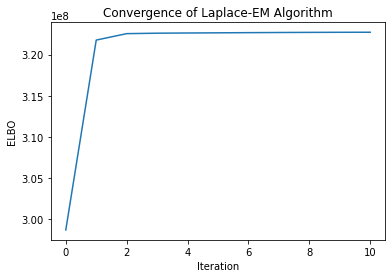

In [39]:
plt.plot(results[0]['q_lem_elbos'], label="Laplace-EM: Structured Mean-Field Posterior")
plt.title('Convergence of Laplace-EM Algorithm')
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.show()

In [40]:
params = (start_time, duration, start_step, length, data, var_names, emissions_dim, n_disc_states, latent_dim)

In [41]:
save({'params': params, 'results': results}, "../../__data__/slds/one_10min_run")

In [45]:
start_times = [start_time]
thresh = np.Inf

In [61]:
switch_bool = np.diff(results[0]['disc_states']) != 0
inter_switch_times = []
t = 0
for i in range(len(switch_bool)):
    t += 1
    if switch_bool[i]:
        inter_switch_times.append(t)
        t = 0

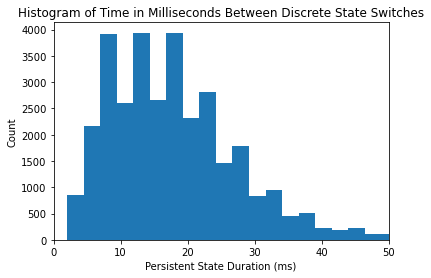

In [67]:
plt.hist(inter_switch_times, bins=100)
plt.title("Histogram of Time in Milliseconds Between Discrete State Switches")
plt.ylabel("Count")
plt.xlabel("Persistent State Duration (ms)")
plt.xlim([0, 50])
plt.show()